In [1]:
import h5py
import os
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from deepdwi import fourier, util
from deepdwi.models import mri

DIR = os.getcwd()
print(DIR)

/home/zhengguo/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/zhengguo/Softwares/DeepDWI/deepdwi/recons


### read in data

In [2]:
# k-space data
f = h5py.File('../../data/ep2d_diff_2x2x3mm_2x1_kdat_slice_010.h5', 'r')
kdat = f['kdat'][:]
f.close()

kdat_prep = np.squeeze(kdat)
kdat_prep = np.swapaxes(kdat_prep, -2, -3)
kdat_prep = kdat_prep[:, None, :, None, :, :]  # 6 dim

print('kdat shape: ', kdat_prep.shape)

# coil sensitivity maps
f = h5py.File('../../data/ep2d_diff_2x2x3mm_2x1_coil_slice_010.h5', 'r')
coil = f['coil'][:]
f.close()

coil = coil[:, None, :, :]

print('coil shape: ', coil.shape)

kdat shape:  (81, 1, 16, 1, 116, 116)
coil shape:  (16, 1, 116, 116)


### device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cuda


### define Sense as nn.Module

In [4]:
y = kdat_prep[[80], ...]

y_tensor = torch.from_numpy(y).to(device)
c_tensor = torch.from_numpy(coil).to(device)

S = mri.Sense(c_tensor, y_tensor).to(device)

### solve the inverse problem

In [5]:
x_torch = torch.zeros(S.xshape, dtype=y_tensor.dtype,
                      requires_grad=True, device=device)

loss = nn.MSELoss(reduction='sum')
optimizer = optim.Adam([x_torch], lr=0.001)

for epoch in range(100):
    fwd = S(x_torch)
    res = loss(torch.view_as_real(y_tensor), torch.view_as_real(fwd))

    optimizer.zero_grad()
    res.backward()
    optimizer.step()

    print('> epoch %3d loss %15.6f'%(epoch, res.item()))

> epoch   0 loss        0.000014
> epoch   1 loss        0.008435
> epoch   2 loss        0.000546
> epoch   3 loss        0.001843
> epoch   4 loss        0.004849
> epoch   5 loss        0.003567
> epoch   6 loss        0.000951
> epoch   7 loss        0.000028
> epoch   8 loss        0.001146
> epoch   9 loss        0.002352
> epoch  10 loss        0.002163
> epoch  11 loss        0.001004
> epoch  12 loss        0.000104
> epoch  13 loss        0.000174
> epoch  14 loss        0.000868
> epoch  15 loss        0.001302
> epoch  16 loss        0.001041
> epoch  17 loss        0.000414
> epoch  18 loss        0.000027
> epoch  19 loss        0.000154
> epoch  20 loss        0.000536
> epoch  21 loss        0.000715
> epoch  22 loss        0.000518
> epoch  23 loss        0.000173
> epoch  24 loss        0.000012
> epoch  25 loss        0.000134
> epoch  26 loss        0.000343
> epoch  27 loss        0.000390
> epoch  28 loss        0.000236
> epoch  29 loss        0.000054
> epoch  3

(1, 1, 16, 1, 116, 116)


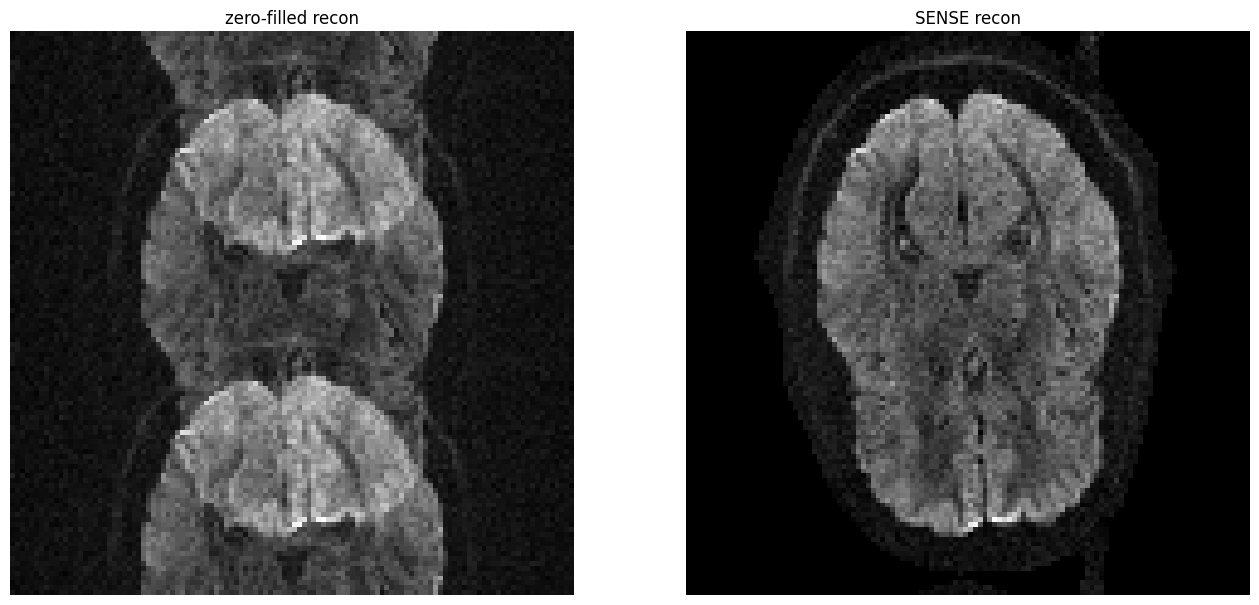

In [7]:
mask = np.sqrt(np.sum(abs(coil)**2, axis=0)) > 0

print(y.shape)

x_zf = util.rss(fourier.ifft(y_tensor, dim=(-2, -1)), dim=-4)
x_zf = np.squeeze(x_zf).cpu().detach().numpy()

x_arr = x_torch.cpu().detach().numpy()
x_arr = mask * x_arr

f, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(np.squeeze(abs(x_zf)), cmap='gray')
ax[0].set_title('zero-filled recon')

ax[1].imshow(np.squeeze(abs(x_arr)), cmap='gray')
ax[1].set_title('SENSE recon')

for n in range(2):
    ax[n].set_axis_off()

plt.show()